<a href="https://colab.research.google.com/github/cometku/SEESMosquitoMappers/blob/master/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten
from sklearn.metrics import confusion_matrix
from scipy import misc, ndimage

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#we will change these
base_path = input('What is your path to your folders? ')
base_path = os.path.join('/content/gdrive', base_path)
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

What is your path to your folders? My Drive/NewPlots


In [4]:
categories = [f.name for f in os.scandir(train_path) if os.path.isdir(f)]
categories

['Water',
 'Trees_Canopycover',
 'Impervious Surface (No Building)',
 'Bush_or_Scrub',
 'Grass',
 'Bare Ground',
 'Cultivated Vegetation',
 'Building']

In [5]:
train_batches = ImageDataGenerator().flow_from_directory(
    train_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=20
)
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=10
)
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=10
)

Found 6661 images belonging to 8 classes.
Found 1325 images belonging to 8 classes.
Found 0 images belonging to 8 classes.


In [6]:
xception_prebuilt = applications.Xception(include_top=False, input_shape=(128,128,3))

In [7]:
xception_model = Sequential()

xception_model.add(xception_prebuilt)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(BatchNormalization())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(BatchNormalization())
xception_model.add(Dense(len(categories), activation='softmax'))

In [9]:
xception_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
xception_model = load_model(r'/content/gdrive/My Drive/best_xception_model2.h5')

In [27]:
xception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4

In [12]:
checkpoint = ModelCheckpoint(

    '/content/gdrive/My Drive/best_xception_model2.h5',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    factor = 0.25,
    patience = 3,
    min_delta = 0.001,
    verbose = 1
)

early_stop = EarlyStopping(
    min_delta = 0.0005,
    patience = 5,
    verbose = 1
)

In [13]:

history = xception_model.fit(
    train_batches,
    steps_per_epoch=333,
    validation_data=valid_batches,
    validation_steps=132,
    epochs=25,
    callbacks = [checkpoint, reduce_lr, early_stop],
    verbose=1
)

Epoch 1/25
  1/333 [..............................] - ETA: 0s - loss: 7.5090 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

In [19]:
xception_model.save('/content/gdrive/My Drive/final_xception_model2.h5')

KeyboardInterrupt: ignored

In [14]:
import pickle as pkl
with open('/content/gdrive/My Drive/xception_history2', 'wb') as hist:
    pkl.dump(history.history, hist)

NameError: ignored

In [10]:
predictions = xception_model.predict(test_batches, steps=270, verbose=0)

ValueError: ignored

In [ ]:
def plot_history(history):

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

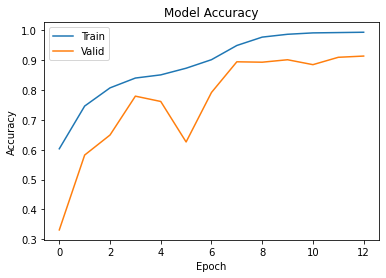

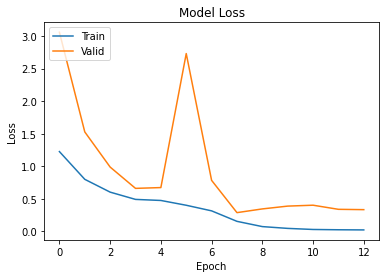

In [ ]:
plot_history(history)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')